In [2]:
from mlbox.preprocessing import *
from mlbox.optimisation import *
from mlbox.prediction import *

/usr/local/lib/python3.6/site-packages/mlbox/preprocessing/drift/__init__.py:9: UserWarning: ipCluster is starting. Please wait 30 sec and check in terminal that 'the engines appear to have started successfully'.
  warnings.warn("ipCluster is starting. "
Using Theano backend.
/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Data

In [7]:
paths = ["/var/data/train.csv","/var/data/test.csv"]
target_name = "SalePrice"

### Reading and cleaning

In [8]:
rd = Reader(sep = ',')
df = rd.train_test_split(paths, target_name)


reading csv : train.csv ...
cleaning data...
CPU time: 32.33097958564758 seconds

reading csv : test.csv ...
cleaning data...
CPU time: 0.14587616920471191 seconds

number of common features : 80

Gathering and crunching for train and test datasets
reindexing for train and test datasets
Dropping training duplicates
Dropping constant variables on training set

number of categorical features: 43
number of numerical features: 37
number of training samples : 1460
number of test samples : 1459

Top sparse features (% missing values on train set):
PoolQC         99.5
MiscFeature    96.3
Alley          93.8
Fence          80.8
FireplaceQu    47.3
dtype: float64

task : regression


### Drift variables

In [9]:
dft = Drift_thresholder()
df = dft.fit_transform(df)


computing drifts...
CPU time: 0.6662700176239014 seconds

Top 10 drifts

('Id', 0.9993141289437586)
('GarageYrBlt', 0.058603155187046063)
('Exterior1st', 0.051728220022389637)
('TotalBsmtSF', 0.047797384757831907)
('2ndFlrSF', 0.042466584861516665)
('Exterior2nd', 0.042145856162453033)
('BsmtFullBath', 0.040377812116377587)
('GrLivArea', 0.039437274266823197)
('TotRmsAbvGrd', 0.038939865235153803)
('WoodDeckSF', 0.037307853783462352)

deleted variables : ['Id']

dumping drift coefficients into directory : save
drift coefficients dumped


### Tuning

In [10]:
mape = make_scorer(lambda y_true, y_pred: 100*np.sum(np.abs(y_true-y_pred)/y_true)/len(y_true), greater_is_better=False, needs_proba=False)
opt = Optimiser(scoring = mape, n_folds = 3)

/usr/local/lib/python3.6/site-packages/mlbox/optimisation/optimiser.py:78: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")


In [11]:
opt.evaluate(None, df)

No parameters set. Default configuration is tested

##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'max_depth': -1, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 50000, 'subsample_freq': 1}


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -16.5341439839
VARIANCE : 1.97629012246 (fold 1 = -19.2995459292, fold 2 = -15.502153765, fold 3 = -14.8007322575)
CPU time: 2.2502541542053223 seconds



-16.534143983908127

In [12]:
space = {
    
        'ne__numerical_strategy':{"search":"choice",
                                 "space":[0]},
        'ce__strategy':{"search":"choice",
                        "space":["label_encoding","random_projection", "entity_embedding"]}, 
        'fs__threshold':{"search":"uniform",
                        "space":[0.01,0.3]},    
        'est__max_depth':{"search":"choice",
                                  "space":[3,4,5,6,7]}
    
        }

best = opt.optimise(space, df, 15)


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.265960434562016}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 7, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 50000, 'subsample_freq': 1}



/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)



MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -16.8649109361
VARIANCE : 1.89835227809 (fold 1 = -19.5192970219, fold 2 = -15.885982072, fold 3 = -15.1894537144)
CPU time: 2.6067376136779785 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'entity_embedding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.27169988792353805}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 6, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 50000, 'subsample_freq': 1}



/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)



MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -16.6881187515
VARIANCE : 1.97936321021 (fold 1 = -19.4508030101, fold 2 = -15.6972889044, fold 3 = -14.9162643401)
CPU time: 84.33000421524048 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.013722409005227053}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 6, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 50000, 'subsample_freq': 1}



/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)



MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -16.7507609343
VARIANCE : 1.93479162303 (fold 1 = -19.4537160095, fold 2 = -15.7675948579, fold 3 = -15.0309719353)
CPU time: 2.7068753242492676 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.10612004092798788}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 5, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 50000, 'subsample_freq': 1}



/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)



MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -17.0524912503
VARIANCE : 1.97070918693 (fold 1 = -19.7887760885, fold 2 = -16.1427166012, fold 3 = -15.2259810613)
CPU time: 2.6652166843414307 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'entity_embedding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.1772773064264918}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 5, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 50000, 'subsample_freq': 1}



/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)



MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -17.0624667542
VARIANCE : 1.94371378113 (fold 1 = -19.7627568518, fold 2 = -16.157697879, fold 3 = -15.2669455318)
CPU time: 4.046549558639526 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.10707089781212485}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 7, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 50000, 'subsample_freq': 1}



/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)



MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -16.7054136804
VARIANCE : 1.96292845132 (fold 1 = -19.4405275906, fold 2 = -15.7489480543, fold 3 = -14.9267653961)
CPU time: 2.548145055770874 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.16812769318812357}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 6, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 50000, 'subsample_freq': 1}



/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)



MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -16.8858681138
VARIANCE : 1.89224352057 (fold 1 = -19.5102770997, fold 2 = -16.0266938821, fold 3 = -15.1206333595)
CPU time: 2.784838914871216 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.2036144804169243}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 5, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 50000, 'subsample_freq': 1}



/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)



MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -17.3431605874
VARIANCE : 1.84536447609 (fold 1 = -19.9061665821, fold 2 = -16.4874571643, fold 3 = -15.6358580156)
CPU time: 2.0063672065734863 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.21105302142173285}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 6, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 50000, 'subsample_freq': 1}



/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)



MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -16.9923133573
VARIANCE : 1.9980752935 (fold 1 = -19.7731345725, fold 2 = -16.0363361099, fold 3 = -15.1674693894)
CPU time: 2.814169406890869 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.13826289724965438}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 5, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 50000, 'subsample_freq': 1}



/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)



MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -17.1699723385
VARIANCE : 1.95676536665 (fold 1 = -19.8745532085, fold 2 = -16.3249567686, fold 3 = -15.3104070386)
CPU time: 2.035599946975708 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'entity_embedding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.07059580231336794}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 6, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 50000, 'subsample_freq': 1}



/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)



MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -16.6881187515
VARIANCE : 1.97936321021 (fold 1 = -19.4508030101, fold 2 = -15.6972889044, fold 3 = -14.9162643401)
CPU time: 4.998997449874878 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.027173881231232412}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 6, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 50000, 'subsample_freq': 1}



/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)



MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -16.7507609343
VARIANCE : 1.93479162303 (fold 1 = -19.4537160095, fold 2 = -15.7675948579, fold 3 = -15.0309719353)
CPU time: 2.886138439178467 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.0345905002647778}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 7, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 50000, 'subsample_freq': 1}



/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)



MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -16.5876419381
VARIANCE : 1.97066590683 (fold 1 = -19.3410274068, fold 2 = -15.5843625406, fold 3 = -14.837535867)
CPU time: 3.052093744277954 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.20466159731939007}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 6, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 50000, 'subsample_freq': 1}



/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)



MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -16.9604176418
VARIANCE : 1.85780182567 (fold 1 = -19.5416575023, fold 2 = -16.0941113008, fold 3 = -15.2454841222)
CPU time: 2.337925910949707 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'entity_embedding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.22916667558283652}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 3, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 50000, 'subsample_freq': 1}



/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)



MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -18.2926657197
VARIANCE : 1.76978407152 (fold 1 = -20.7563379287, fold 2 = -17.4428543847, fold 3 = -16.6788048456)
CPU time: 3.5341434478759766 seconds



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ BEST HYPER-PARAMETERS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

{'ce__strategy': 'label_encoding', 'est__max_depth': 7, 'fs__threshold': 0.0345905002647778, 'ne__numerical_strategy': 0}



fitting the pipeline...


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


CPU time: 1.0870656967163086 seconds

dumping feature importances into directory : save


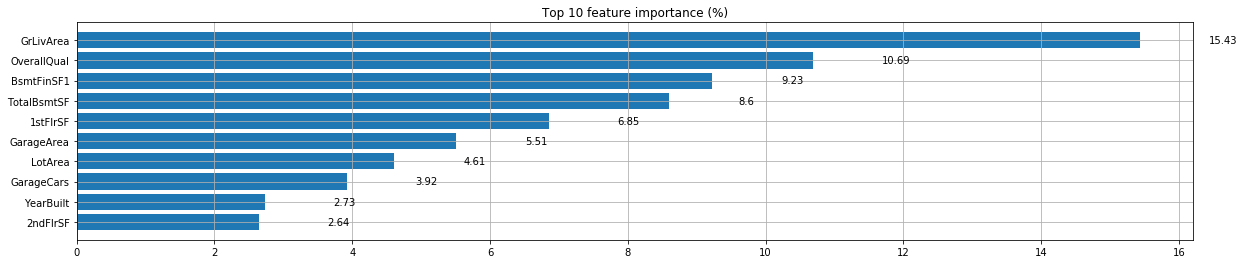


predicting...
CPU time: 0.09231114387512207 seconds

top 10 predictions :

   SalePrice_predicted
0        134646.079394
1        143817.496369
2        168748.287432
3        181909.512739
4        202277.986126
5        174554.551879
6        167694.244607
7        167954.343732
8        180581.160646
9        132315.704908

dumping predictions into directory : save


In [13]:
prd = Predictor()
prd.fit_predict(best, df)